# HW2-Income Prediction
*By Binary Classification*
- **Author:** Fan Simin
- **Instructor:** Hongyi Lee

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Logistic Regression


### Data Preprocessing
- Get Dataset
- Normalization
- Train/Dev Split

In [14]:
with open('X_train') as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
    
with open('Y_train') as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)

with open('X_test') as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
        
X_train

array([[33.,  1.,  0., ..., 52.,  0.,  1.],
       [63.,  1.,  0., ..., 52.,  0.,  1.],
       [71.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [16.,  0.,  0., ...,  8.,  1.,  0.],
       [48.,  1.,  0., ..., 52.,  0.,  1.],
       [48.,  0.,  0., ...,  0.,  0.,  1.]])

In [15]:
sampleDF = pd.read_csv('train.csv')
sampleDF

,id,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,y
0,0,33,Private,34,26,Masters degree(MA MS MEng MEd MSW MBA),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,...,China,China,Taiwan,Foreign born- Not a citizen of U S,2,Not in universe,2,52,95,50000+.
1,1,63,Private,7,22,Some college but no degree,0,Not in universe,Never married,Manufacturing-durable goods,...,?,?,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
2,2,71,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,...,Germany,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
3,3,43,Local government,43,10,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Education,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
4,4,57,Local government,40,32,Some college but no degree,0,Not in universe,Widowed,Entertainment,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
5,5,42,Private,16,4,Masters degree(MA MS MEng MEd MSW MBA),0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,...,India,India,India,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,50000+.
6,6,16,Not in universe,0,0,11th grade,0,High school,Never married,Not in universe or children,...,Peru,?,United-States,Native- Born in the United States,2,Not in universe,2,3,94,- 50000.
7,7,16,Private,33,19,10th grade,0,High school,Never married,Retail trade,...,El-Salvador,El-Salvador,El-Salvador,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
8,8,20,Private,5,36,High school graduate,0,Not in universe,Never married,Manufacturing-durable goods,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,24,95,- 50000.
9,9,38,Not in universe,0,0,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Not in universe or children,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,94,- 50000.


In [16]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column], axis = 0).reshape(1, -1)
        X_std = np.std(X[:, specified_column], axis = 0).reshape(1, -1)
    X[:, specified_column] = (X[:, specified_column]-X_mean)/(X_std+ 1e-8)
    return X, X_mean, X_std

def _train_dev_split(X, Y, split_ratio=0.8):
    train_set = int(X.shape[0]*split_ratio)
    return X[:train_set],Y[:train_set], X[train_set:], Y[train_set:]
    
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _ = _normalize(X_test, train = False, X_mean = X_mean, X_std = X_std)
X_trainSet, Y_trainSet, X_devSet, Y_devSet = _train_dev_split(X_train, Y_train, 0.85)
print(Y_trainSet.shape)

(46117,)


In [20]:
train_size = X_trainSet.shape[0]
dev_size = X_devSet.shape[0]
test_size = X_test.shape[0]
print(f'train_size:{train_size}')
print(f'dev_size:{dev_size}')
print(f'test_size:{test_size}')
def _sigmoid(z):
    return np.clip(1/(1+np.exp(-z)), 1e-8, 1-(1e-8));

def _f(X, w, b):
    return _sigmoid(np.matmul(X, w)+b)

def _predict(X, w, b):
    return np.round(_f(X, w, b)).astype(np.int)

def _accuracy(Y_pred, Y_label):
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

def _cross_entropy_loss(Y_label, y_pred):
    crossEntropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1-Y_label), np.log(1-y_pred))
    return crossEntropy

def _gradient(X, Y_label, w, b):
    y_pred = _f(X, w, b)
#     print('X:', X.shape)
#     print('Y_label:',Y_label.shape)
#     print('y_pred:', y_pred.shape)
#     print('w:', w.shape)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error*X.T, axis = 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad
X_trainSet.shape

train_size:46117
dev_size:8139
test_size:27622


(46117, 510)

## Training

### 1. Mini-Batch
- Calculate the gradient and loss according to each mini-batch, and update parameters.
- Shuffle after each epoch

In [22]:
from tqdm import tqdm

def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def initialize_parameters(X):
    dims = X.shape[1]
    w = np.zeros((dims,) )
    b = np.zeros((1, ))   
    return w, b

def train_model(X_train, Y_train, X_dev, Y_dev, batch_size = 200, epochs = 100, lr = 0.5):
    trainLoss = []
    trainAcc=[]
    devLoss = []
    devAcc = []
    w_Grads = []
    b_Grads = []
    train_size = X_train.shape[0]
    dev_size = X_dev.shape[0]
    w, b = initialize_parameters(X_train)
    for epoch in range(epochs):
        X_train, Y_train = _shuffle(X_train, Y_train)
        with tqdm(total = int(train_size/batch_size), desc = f'epoch{epoch+1}:') as pbar:
            for batch in range(int(train_size/batch_size)):
                if batch_size*(batch+1)<train_size :
                    X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
                    Y_batch = Y_train[batch*batch_size:(batch+1)*batch_size]
                else:
                    X_batch = X_train[batch*batch_size:]
                    Y_batch = Y_train[batch*batch_size:]              
    #             X_batch = (batch_size*(batch+1)<train_size)? X_train[batch*batch_size:(batch+1)*batch_size]:X_train[batch*batch_size:]
    #             Y_batch = (batch_size*(batch+1)<train_size)? Y_train[batch*batch_size:(batch+1)*batch_size]:Y_train[batch*batch_size:]
                w_grad_batch, b_grad_batch = _gradient(X_batch, Y_batch, w, b)
                
                w = w-lr* w_grad_batch /np.sqrt(batch+1)
                b = b-lr*b_grad_batch / np.sqrt(batch+1)
                pbar.update(1)
            
            
        y_hat = _f(X_train, w, b)
        y_dev_pred =_f(X_dev, w, b)
#         print(X_train.shape)
#         print(w.shape)
#         print(Y_train.shape)
#         print(y_hat.shape)
        epoch_loss = _cross_entropy_loss(Y_train, y_hat)
        dev_loss = _cross_entropy_loss(Y_dev, y_dev_pred)
        y_hat_output = np.round(_f(X_train, w, b))
        y_dev_pred_output = np.round(_f(X_dev, w, b))
        dev_acc = _accuracy(y_dev_pred_output, Y_dev)
        train_acc = _accuracy(y_hat_output, Y_train)
        trainLoss.append(epoch_loss/train_size)
        devLoss.append(dev_loss/dev_size)
        trainAcc.append(train_acc)
        devAcc.append(dev_acc)
        w_Grads.append(w_grad_batch)
        b_Grads.append(b_grad_batch)
#         print(f'Epoch{epoch+1}: training loss={epoch_loss/train_size}, dev loss = {dev_loss/dev_size};')
    parameters = {}
    parameters['weights'] = w
    parameters['bias'] = b
    parameters['train_Loss'] = trainLoss
    parameters['train_Accuracy'] = trainAcc
    parameters['dev_Loss'] = devLoss
    parameters['dev_Accuracy'] = devAcc
    return parameters
        
parameters = train_model(X_trainSet, Y_trainSet, X_devSet, Y_devSet)
    
    

epoch68:: 100%|████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 2395.76it/s]


epoch100:: 100%|███████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 2804.62it/s]


## Plot Loss/Acc Curve

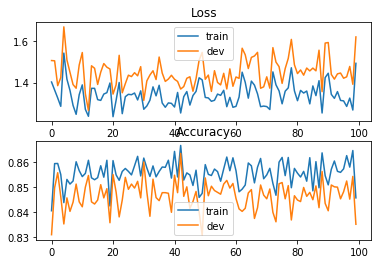

In [31]:
# print(parameters['train_Loss'])

def Loss_Acc_Curve(parameters):
    trainLoss = parameters['train_Loss']
    devLoss = parameters['dev_Loss']
    trainAcc = parameters['train_Accuracy']
    devAcc = parameters['dev_Accuracy']
    # Loss Curve
    plt.subplot(211)
    plt.plot(trainLoss)
    plt.plot(devLoss)
    plt.title('Loss')
    plt.legend(['train', 'dev'])
    
    # Accuracy Curve
    plt.subplot(212)
    plt.plot(trainAcc)
    plt.plot(devAcc)
    plt.title('Accuracy')
    plt.legend(['train', 'dev'])
    
    plt.savefig('loss_acc.png')
    plt.show()

Loss_Acc_Curve(parameters)


## Test

In [44]:
# for i in range(len(parameters['train_Loss'])):
#     if np.abs(parameters['train_Loss'][i]) == np.min(np.abs(parameters['train_Loss'])):
#         weight_output = parameters['weights'][i]
#         bias_output = parameters['bias'][0]
w = parameters['weights']
b = parameters['bias']
# print(w)
# print(b)
# print(weight_output)
# print(bias_output)
predictions = _predict(X_test, w, b)
with open('./fsm_submission_hw2', 'w') as f:
    f.write('id, label\n')
    for j, label in enumerate(predictions):
        f.write(f'{j},{label}\n')
        
# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open('X_test') as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Grandchild 18+ ever marr RP of subfamily -66.7938198003624
dividends from stocks -42.2284022952009
 2 -28.44376825639993
 High school graduate -28.394259857485164
 No 24.129967936130505
 Philippines -20.04629453922582
 Local government -18.201880652685762
 Not in universe -17.671380060981285
num persons worked for employer 16.526670542406208
 El-Salvador -16.254377607437885
